In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from model.ae import VariationalAutoencoder
from utils.loss import calculate_kl_loss
from tqdm.notebook import tqdm

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, dataset_path):
        self.spectrograms = []

        for root, _, file_names in os.walk(dataset_path):
            for file_name in file_names:
                file_path = os.path.join(root, file_name)
                spectrogram = np.load(file_path) # (n_bins, n_frames)
                self.spectrograms.append(spectrogram)

        self.spectrograms = torch.from_numpy(np.array(self.spectrograms)).unsqueeze(1) # Add channel dimension

    def __len__(self):
        return self.spectrograms.shape[0]

    def __getitem__(self, index):
        return self.spectrograms[index]


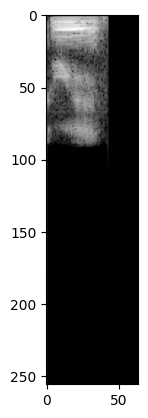

In [3]:
dataset_path = "./processed_data/spectrograms"
dataset = SpectrogramDataset(dataset_path)
sample_image = dataset.__getitem__(2003)

plt.imshow(sample_image.squeeze(0), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.show()

In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Verify the download by printing some info
print(f"Training set size: {len(dataset)}")
print(f"Length of train_loader: {len(train_loader)}")

Training set size: 3000
Length of train_loader: 47


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 512, 256, 128, 64, 32)
convKernels =   (3, 3, 3, 3, 3)
convStrides =   (2, 2, 2, 2, (2, 1))
convPadding =   (0, 0, 0, 0, 0)

# AutoEncoder
vae = VariationalAutoencoder(128, (1, 256, 64), convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)

In [6]:
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

num_params = count_trainable_parameters(vae)
print(f"Total trainable parameters: {num_params:,}")


Total trainable parameters: 3,235,009


In [7]:
vae.mEncoder.output_paddings

[(1, 1), (0, 0), (0, 0), (0, 0), (0, 0)]

## Main Training Loop

In [16]:
alpha = 0.0008
iterations = []
max_epochs = 10

vae.train()
for epoch in range(max_epochs):
    for i, images in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = vae(images)

        kl_loss = calculate_kl_loss(vae.mu, vae.log_variance)
        reconstruction_loss = mse_loss(outputs, images)
        
        loss = reconstruction_loss + alpha * kl_loss
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Reconstruction Loss: {reconstruction_loss}, KL Loss: {kl_loss}, Overall Loss: {loss.detach()}")

torch.save(vae.state_dict(), './saved_models/vae.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Reconstruction Loss: 0.12120950222015381, KL Loss: 1.7197413444519043, Overall Loss: 0.12258529663085938
Epoch: 1, Reconstruction Loss: 0.11412399262189865, KL Loss: 1.6026225090026855, Overall Loss: 0.1154060885310173


KeyboardInterrupt: 

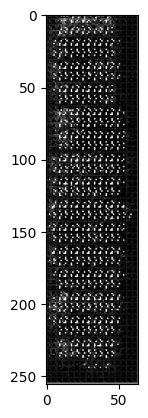

In [19]:
plt.imshow(outputs[0].detach().cpu().squeeze(0), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.show()